# Data split version description
## Version 1
>>
가장 기본적인 random sampling (비복원 추출) 방식을 따랐습니다.\
Random seed는 42로 설정했습니다.\
생성되는 .json 파일은 ufo 폴더 안에 위치하도록 했으며 dataset 별로 모두 ufo 폴더가 있다고 가정하고 진행합니다.

# Load modules

In [1]:
import os
import pandas as pd
import json
import numpy as np
import random
import seaborn as sns
import matplotlib as mpl

from pathlib import Path
from sklearn.model_selection import train_test_split
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold 

## Fix random seed

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load original dataset

In [3]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann    

In [4]:
root_dir = '../input/data/'
path_ICDAR17 = 'ICDAR17_Korean/ufo/'
data_nm = 'train.json'

data = read_json(os.path.join(root_dir, path_ICDAR17, data_nm))

In [5]:
data['images']['img_4380.jpg']['words']

{'0': {'points': [[662.0, 747.0],
   [945.0, 759.0],
   [922.0, 1582.0],
   [673.0, 1565.0]],
  'transcription': '출입금지',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None},
 '1': {'points': [[476.0, 551.0],
   [1132.0, 554.0],
   [1118.0, 747.0],
   [471.0, 716.0]],
  'transcription': '오토바이',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None},
 '2': {'points': [[455.0, 293.0],
   [1144.0, 310.0],
   [1129.0, 518.0],
   [457.0, 496.0]],
  'transcription': '자전거',
  'language': ['ko'],
  'illegibility': False,
  'orientation': 'Horizontal',
  'word_tags': None}}

# Get image properties

In [6]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)


def rectify_poly(poly, direction, img_w, img_h):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0] / img_h
        w = size[:, 1] / img_w
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max() / img_h
        widths = sizes[:, 1]
        w = np.sum(widths) / img_w
        return np.stack((h,w)).reshape(2,-1)
        #return np.stack((h,w))
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max() / img_w
        h = np.sum(heights) / img_h
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0] / img_h
        w = sizes[:, 1] / img_w
        return np.stack((h,w),-1)
    
def get_image_dfs(data):
    df = {}
    df['image'] = []
    df['word_counts'] = []
    df['image_width'] = []
    df['image_height'] = []
    df['image_tags'] = []
    img_tags = []

    quads = []
    polys = []
    seq_length = []
    hor_sizes = []
    ver_sizes = []
    irr_sizes = []
    languages = []
    orientation = []
    word_tags = []
    aspect_ratio = []
    ver_string = []

    bbox_properties = []
    
    for image_key, image_value in data["images"].items():
        df['image'].append(image_key)
        img_w = image_value['img_w']
        img_h = image_value['img_h']
        df['image_width'].append(img_w)
        df['image_height'].append(img_h)
        df['image_tags'].append(image_value['tags'])
        df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
        word_ann = image_value['words']
        count_ill = 0 
        for word in word_ann.values():
            if word['illegibility']== False:
                orientation.append(word['orientation'])
                orientation = [v for v in orientation]
                seq_length.append(len(word['transcription']))
                languages.append(word['language'])
                languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
                if word['word_tags'] != None:
                    word_tags.extend(word['word_tags'][:])
                elif word['word_tags']== None:
                    word_tags.append('None')
                poly = np.int32(word['points'])
                size = rectify_poly(poly, word['orientation'], img_w, img_h)
                if word['orientation'] == 'Horizontal':
                    hor_sizes.append(size)
                    bbox_properties.append([image_key, size, 'Horizontal'])
                    # print(image_key, size, 'Horizontal')
                elif word['orientation'] == 'Vertical':
                    ver_sizes.append(size)
                    bbox_properties.append([image_key, size, 'Vertical'])
                    # print(image_key, size, 'Vertical')
                else:
                    irr_sizes.append(size)
                    bbox_properties.append([image_key, size, 'Irregular'])
            else:
                count_ill += 1

        df['word_counts'].append(len(word_ann)-count_ill)


    all_sizes = hor_sizes + ver_sizes + irr_sizes
    quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
    total_area = []
    for s in quad_area:
        if s.shape[0] == 1:
            total_area.append(np.sum(s[0])) 
        else:
            total_area.append(np.sum(s))

    hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
    ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

    image_df = pd.DataFrame.from_dict(df)
    bbox_df = pd.DataFrame(data=bbox_properties,
                          columns=['image', 'size', 'orientation'])
    
    bbox_df['aspect_ratio'] = bbox_df.apply(lambda x: (x['size'][1]/x['size'][0])[0], axis=1)
    
    return image_df, bbox_df
    

In [7]:
image_df, bbox_df = get_image_dfs(data)

In [8]:
# Check image data frame
image_df

,image,word_counts,image_width,image_height,image_tags
0,img_4380.jpg,3,1836,2448,[None]
1,img_4583.jpg,2,2268,2268,[None]
2,img_4234.jpg,7,2592,3456,[None]
3,img_4345.jpg,7,1836,2448,[None]
4,img_4016.jpg,1,1836,2448,[None]
...,...,...,...,...,...
531,img_1048.jpg,4,3024,2268,[None]
532,img_1071.jpg,2,2448,1836,[None]
533,img_1122.jpg,8,2448,1836,[None]
534,img_1131.jpg,1,3144,2328,[None]


In [9]:
# Check bbox dataframe
bbox_df

,image,size,orientation,aspect_ratio
0,img_4380.jpg,"[[0.335375816993464], [0.144880174291939]]",Horizontal,0.431994
1,img_4380.jpg,"[[0.07312091503267974], [0.355119825708061]]",Horizontal,4.856611
2,img_4380.jpg,"[[0.08415032679738563], [0.3709150326797386]]",Horizontal,4.407767
3,img_4583.jpg,"[[0.09259259259259259], [0.6247795414462081]]",Horizontal,6.747619
4,img_4583.jpg,"[[0.09832451499118165], [0.6318342151675485]]",Horizontal,6.426009
...,...,...,...,...
3603,img_1122.jpg,"[[0.037037037037037035], [0.0763888888888889]]",Horizontal,2.062500
3604,img_1122.jpg,"[[0.03649237472766884], [0.053513071895424834]]",Horizontal,1.466418
3605,img_1131.jpg,"[[0.15936426116838487], [0.602735368956743]]",Horizontal,3.782124
3606,img_1100.jpg,"[[0.31917211328976036], [0.7777777777777778]]",Horizontal,2.436860


# Get validation version 1

In [10]:
# Split images at random
X_train_v1, X_valid_v1, y_train_v1, y_valid_v1 = \
train_test_split(image_df.image, image_df.image, test_size=0.2, shuffle=True, random_state=seed)

In [11]:
# Simple check split result
print(sum(X_train_v1!=y_train_v1))
print(set(y_train_v1).intersection(set(y_valid_v1)))

0
set()


In [12]:
type(data['images'])

dict

In [13]:
train_v1 = {'images': {k: v for k, v in data['images'].items() if k in X_train_v1.values}}
valid_v1 = {'images': {k: v for k, v in data['images'].items() if k in X_valid_v1.values}}

In [14]:
# Just for check
print(len(train_v1['images']))
print(len(valid_v1['images']))

428
108


# Save validation version 1

In [15]:
def save_json(data: dict, file_nm: str, dir_path: str):
    with open(os.path.join(dir_path, file_nm), 'w') as outfile:
        json.dump(data, outfile)

In [16]:
data_list = [train_v1,
             valid_v1
            ]
file_nm_list = ['train_v1.json',
                'valid_v1.json',
               ]

for data, file_nm in zip(data_list, file_nm_list):
    save_json(data, file_nm, dir_path=os.path.join(root_dir, path_ICDAR17))

# Get validation version 2

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='aspect_ratio'>

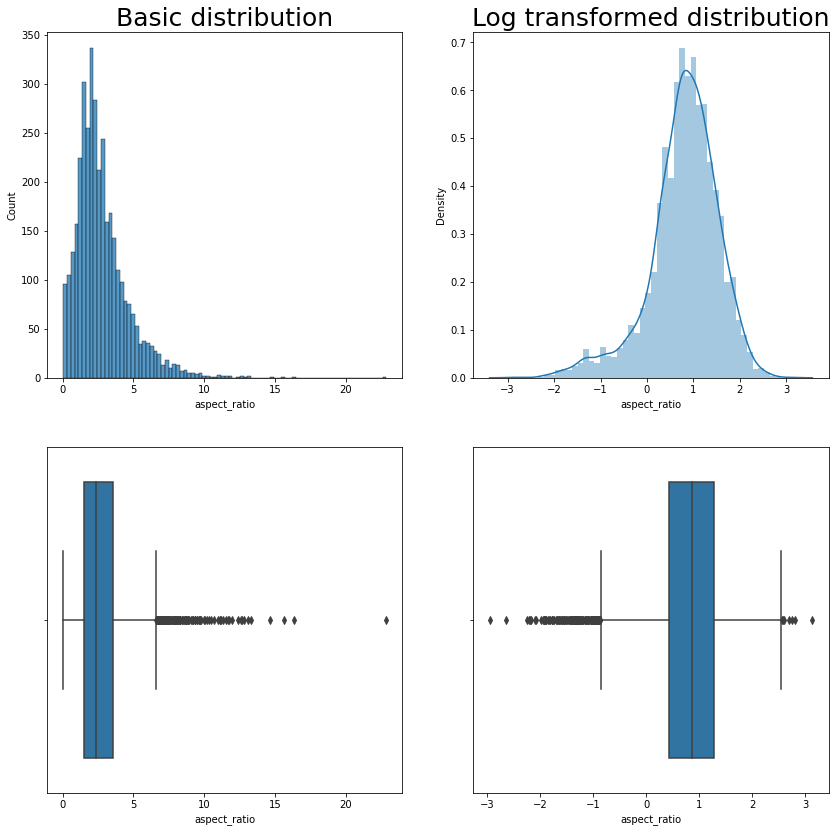

In [27]:
# Plot - Check aspect ratio distribution
fig_aspect_ratio, ax_aspect_ratio = plt.subplots(2, 2, figsize=(14, 14))

sns.histplot(bbox_df.aspect_ratio, ax=ax_aspect_ratio[0, 0])
ax_aspect_ratio[0, 0].set_title('Basic distribution', fontsize=25)

sns.boxplot(bbox_df.aspect_ratio, ax=ax_aspect_ratio[1, 0])

sns.distplot(np.log(bbox_df.aspect_ratio), ax=ax_aspect_ratio[0, 1])
ax_aspect_ratio[0, 1].set_title('Log transformed distribution', fontsize=25)

sns.boxplot(np.log(bbox_df.aspect_ratio), ax=ax_aspect_ratio[1, 1])

In [40]:
def auto_binning(data:pd.Series, min_elements=10, log_transform=True, print_outlier_percent=False):
    # The goal of this function is binning a continuous-valued 1-d sequence for stratified splitting
    """
    Approximate the distribution of continuous 1-d sequence as a discrete distribution by pandas cut function

    Args:
        data: Input 1-d sequence as a pandas format.
        min_elements: The number of miminum elements for a bin.
                      It is used for finding moderate number of bins.
        log_transform: Whether using natural log transformation before binning or not.
        print_outlier_percent: Whether printing outlier ratio among whole dataset or not.

    Returns:
        1-d pandas series with discrete class
    """   
    assert type(data) is pd.Series
    
    def bind_outlier(data: pd.Series, print_outlier_percent=False):
        """
        Outlier binding function for 1-d array.
        Outlier is determined by statistical convention using 25 & 75 percentile and IQR 

        Args:
            data: Input 1-d sequence as a pandas format.
            print_outlier_percent: Whether printing outlier ratio among whole dataset or not.

        Returns:
            It returns the outlier binded 1-d array.
        """    
        assert type(data) is pd.Series

        cnt_outlier = 0

        q1, q3 = np.percentile(data, 25), np.percentile(data, 75)
        lower = q1 - 1.5*(q3-q1)
        upper = q3 + 1.5*(q3-q1)

        new_data = deepcopy(data)

        cnt_outlier += len(new_data[new_data <= lower])
        new_data[new_data <= lower] = lower

        cnt_outlier += len(new_data[new_data >= upper])
        new_data[new_data >= upper] = upper

        if print_outlier_percent:
            print(f'Outliers account for [{100*cnt_outlier/len(data):.3f}]% of total data')

        return new_data
    
    # binding outlier
    if log_transform:
        binded_data = bind_outlier(np.log(data), print_outlier_percent)
    else:
        binded_data = bind_outlier(data, print_outlier_percent)
        
    num_bins = 10
    max_iter_limit = 9999
    iter_cnt = 0
    while True:
        dist_approx = pd.cut(binded_data, bins=num_bins, labels=np.arange(num_bins))
        min_elem_cnt = dist_approx.value_counts().min() # Miminum number of elements for a bin
        
        if min_elem_cnt < min_elements:
            print(f'Minimum # of elements for a bin is [{min_elem_cnt}]')
            print(f'Number of bins [{num_bins}]')
            break
        
        if iter_cnt > max_iter_limit:
            print('Iteration exceeded limit')
            raise RuntimeError
        
        num_bins += 1
        iter_cnt += 1
    
    return dist_approx

Outliers account for [4.157]% of total data
Minimum # of elements for a bin is [9]
Number of bins [26]


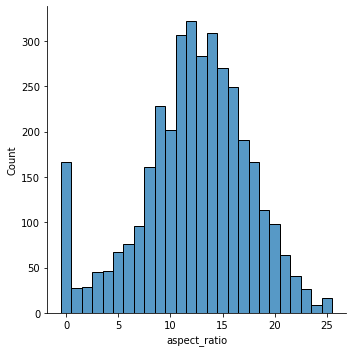

In [19]:
test_auto_binning = auto_binning(bbox_df.aspect_ratio, print_outlier_percent=True)
sns.displot(test_auto_binning)

In [20]:
bbox_df['aspect_class'] = auto_binning(bbox_df.aspect_ratio, print_outlier_percent=False)

Minimum # of elements for a bin is [9]
Number of bins [26]


In [21]:
cv_val_v2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) 

for train_idx_v2, valid_idx_v2 in cv_val_v2.split(bbox_df.aspect_class, bbox_df.aspect_class, bbox_df.image): 
    pass
    
print(f'Length train idx [{len(train_idx_v2)}]')
print(f'Length valid idx [{len(valid_idx_v2)}]')

Length train idx [3001]
Length valid idx [607]


In [22]:
# Device images by aspect ratio class
train_image_v2 = set(bbox_df.image[train_idx_v2])
valid_image_v2 = set(bbox_df.image[valid_idx_v2])

# Check v2 exclusivity
print(f'Intersection between train images v2 & valid images v2 : [{train_image_v2.intersection(valid_image_v2)}]')

train_image_v2 = list(train_image_v2)
valid_image_v2 = list(valid_image_v2)

train_v2 = {'images': {k: v for k, v in data['images'].items() if k in X_train_v1.values}}
valid_v2 = {'images': {k: v for k, v in data['images'].items() if k in X_valid_v1.values}}

Intersection between train images v2 & valid images v2 : [set()]


In [23]:
print(f"Length train v2 [{len(train_v2['images'])}] || valid v2 [{len(valid_v2['images'])}]")

Length train v2 [0] || valid v2 [108]


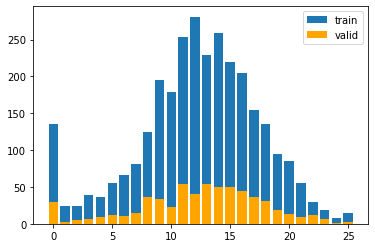

In [24]:
# Plot - version 2 aspect class distribution check
plt.bar(bbox_df.aspect_class[train_idx_v2].value_counts().sort_index().index,
        bbox_df.aspect_class[train_idx_v2].value_counts().sort_index(),
        label='train')
plt.bar(bbox_df.aspect_class[valid_idx_v2].value_counts().sort_index().index,
        bbox_df.aspect_class[valid_idx_v2].value_counts().sort_index(),
        color='orange', label='valid')
plt.legend()

# Save validation version 2

In [26]:
data_list_v2 = [train_v2,
             valid_v2
            ]
file_nm_list_v2 = ['train_v2.json',
                'valid_v2.json',
               ]

for data, file_nm in zip(data_list_v2, file_nm_list_v2):
    save_json(data, file_nm, dir_path=os.path.join(root_dir, path_ICDAR17))